Cette page cherche à fournir une indication graphique de la representatitivté des corpus de lemmatisation. On se sert pour cela des corpus et d'une datation par oeuvre et par auteur.

In [1]:
# Change directory to the root of These for simpler imports
import os
os.chdir("/home/thibault/dev/these/")

# Imports
import csv
from MyCapytain.common.reference import URN
from collections import namedtuple, Counter
from helpers.treebanks import Filtered_Corpora
from pandas import DataFrame, Series
from IPython.display import display, HTML
from helpers.metadata import wordcounts 

## Récupération des dates de corpora

In [2]:
Date = namedtuple("Date", ["birth", "death"])
dates = {}

# On ouvre le fichier qui contient les dates
with open("data/raw/datation.tsv") as f:
    reader = csv.DictReader(f, delimiter="\t")
    # Pour chacune des URN, on remplit avec le textgroup le dictionnaire data
    for line in reader:
        urn = line["URN"]
        # Si on a une URN et que cette ligne ne doit pas être ignorée
        if urn and line["Ignore"] != "x":
            textgroup = (URN(urn)).upTo(URN.TEXTGROUP)
            if textgroup not in dates:
                try:
                    dates[textgroup] = Date(int(line["Birth"]), int(line["Death"]))
                except Exception:
                    print("Erreur sur la ligne suivante :")
                    print(line)
                    raise

all_dates = list([d for tup in dates.values() for d in tup])
Min_date, Max_date = min(all_dates), max(all_dates)
print(Min_date, Max_date)

-254 799


## Parsage des corpora treebanks et lemmatisation

In [3]:
# Les corpora sont lus à la source, chaque fichier parsé
# Ils sont aussi alignés avec des URNs
for corpus in Filtered_Corpora:
    print("Parsing {}".format(corpus.name))
    corpus.parse()

Parsing Harrington Latin (NoPunc)
Parsing Proiel (NoPunc)
Parsing Perseus UD (NoPunc)


0it [00:00, ?it/s]

Parsing Corpus Lasla 2018


In [4]:
lemmatisation_corpora_wordcount = {corpus.name: Counter() for corpus in Filtered_Corpora}
lemmatisation_corpora_textcount = {key: Counter() for key in lemmatisation_corpora_wordcount}
for corpus in Filtered_Corpora:
    for doc in corpus.words:
        textgroup = (URN(doc)).upTo(URN.TEXTGROUP)
        lemmatisation_corpora_wordcount[corpus.name][textgroup] += len(corpus.words[doc])
        lemmatisation_corpora_textcount[corpus.name][textgroup] += 1

### Informations sur les corpora

In [5]:
# On affiche un beau tableau HTML
lemma_corpora = DataFrame({corpus.name: corpus.diversity for corpus in Filtered_Corpora})
display(HTML(lemma_corpora.to_html(notebook=True)))

ZeroDivisionError: division by zero

## Parsage des informations sur les corpus généraux

### Informations issues du catalogue (Parcellaires)

In [6]:
# On récupère les nombres de mots d'après le Perseus Catalog
catalog_wordcount_per_edition = wordcounts.build()
catalog_wordcount = Counter()
catalog_textcount = Counter()

for id_text, count_for_text in catalog_wordcount_per_edition.items():
    tg = str((URN(id_text)).upTo(URN.TEXTGROUP))
    catalog_wordcount[tg] += sum(count_for_text)
    catalog_textcount[tg] += 1

### Information issues des textes bruts disponibles ouvertement

In [7]:
from helpers.reader.curated import get_graph, get_texts, get_text_length_dict
# Retrieve the metadata graph
graph = get_graph()
# And the list of texts as a dictionary of text: text_length
texts = get_texts()
# And the list of texts as a dictionary of text: text_length
available_wordcount_per_edition = get_text_length_dict(texts)
available_wordcount = Counter()
available_textcount = Counter()

for id_text, count_for_text in available_wordcount_per_edition.items():
    tg = str((URN(id_text)).upTo(URN.TEXTGROUP))
    available_wordcount[tg] += sum(count_for_text)
    available_textcount[tg] += 1

## Représentativité en mots des corpus d'entraînement

Ci-dessous, transformation des données en DataFrame afin de pouvoir filtrer facilement/

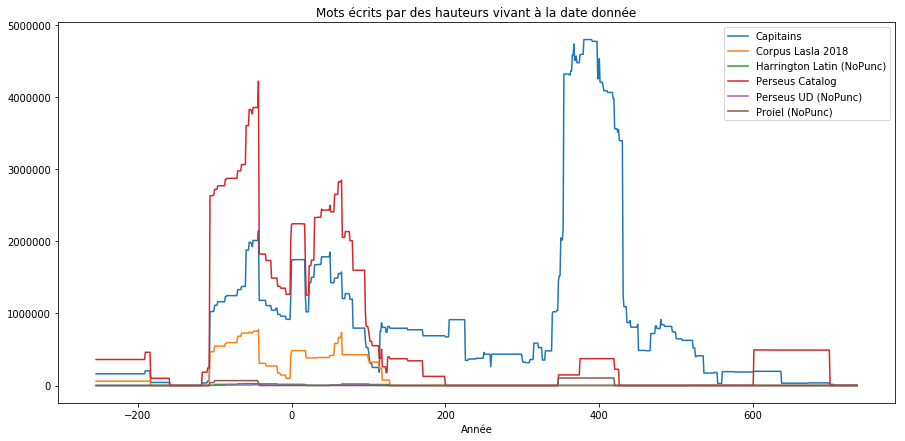

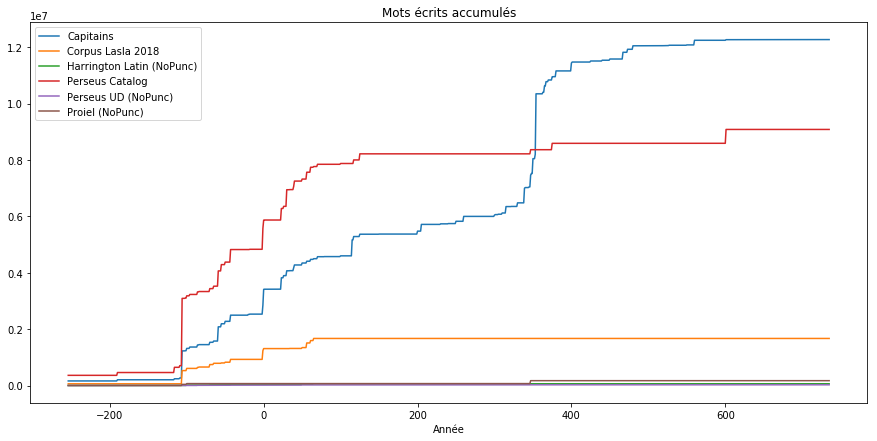

In [11]:
serie = DataFrame([
    {
        "birth": date.birth,
        "death": date.death,
        "Perseus Catalog": catalog_wordcount.get(urn, 0),
        "Capitains": available_wordcount.get(urn, 0),
        **{
           corpus: lemmatisation_corpora_wordcount[corpus].get(urn, 0) for corpus in lemmatisation_corpora_wordcount 
        }
    } 
    for urn, date in dates.items()
])


# On liste les colomnes utiles dynamiquement en supprimant celles sans intérêt
cols_to_keep = set(list(serie.columns))
cols_to_keep.remove('death')
cols_to_keep.remove('birth')

# Get simultaneous tokens
token_simultaneous = {}
for date in range(Min_date, Max_date+1):
    token_simultaneous[date] = serie[((serie.birth <= date) & (serie.death >= date))][list(cols_to_keep)].sum()
token_simultaneous = DataFrame([{"Année": date, **token_simultaneous[date]} for date in token_simultaneous])

# Get cumulative tokens
token_cumulative = {}
for date in range(Min_date, Max_date+1):
    token_cumulative[date] = serie[(serie.birth <= date)][list(cols_to_keep)].sum()
token_cumulative = DataFrame([{"Année": date, **token_cumulative[date]} for date in token_cumulative])


x = token_simultaneous.plot(x="Année", title="Mots écrits par des hauteurs vivant à la date donnée", figsize=(15, 7))
x = token_cumulative.plot(x="Année", title="Mots écrits accumulés", figsize=(15, 7))

## Représentativité en nombre de texte des corpus d'entraînement

Ci-dessous, transformation des données en DataFrame afin de pouvoir filtrer facilement.

,Année,Capitains,Corpus Lasla 2018,Harrington Latin (NoPunc),Perseus Catalog,Perseus UD (NoPunc),Proiel (NoPunc)
0,-254,20,8,0,22,0,0
1,-204,20,8,0,22,0,0
2,-154,0,0,0,0,0,0
3,-104,70,54,2,152,1,1
4,-54,98,70,7,192,5,2
5,-4,19,7,3,31,3,0
6,46,46,25,0,51,1,0
7,96,30,10,2,42,3,0
8,146,55,0,0,54,0,0
9,196,53,0,0,42,0,0


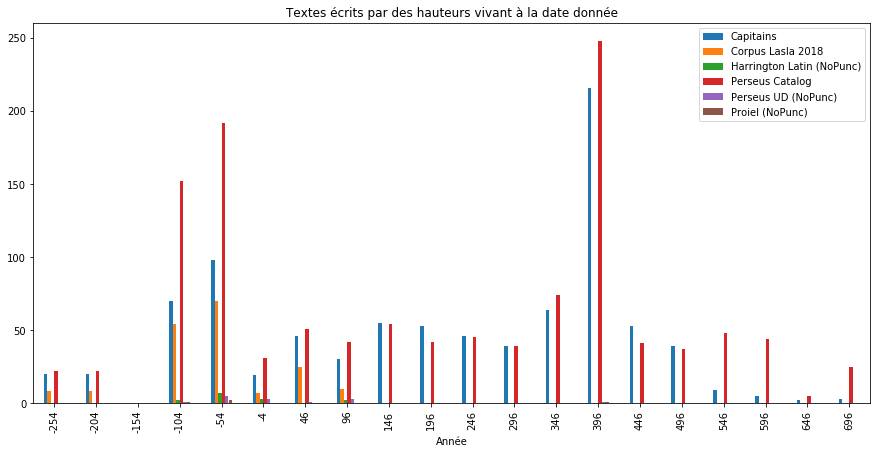

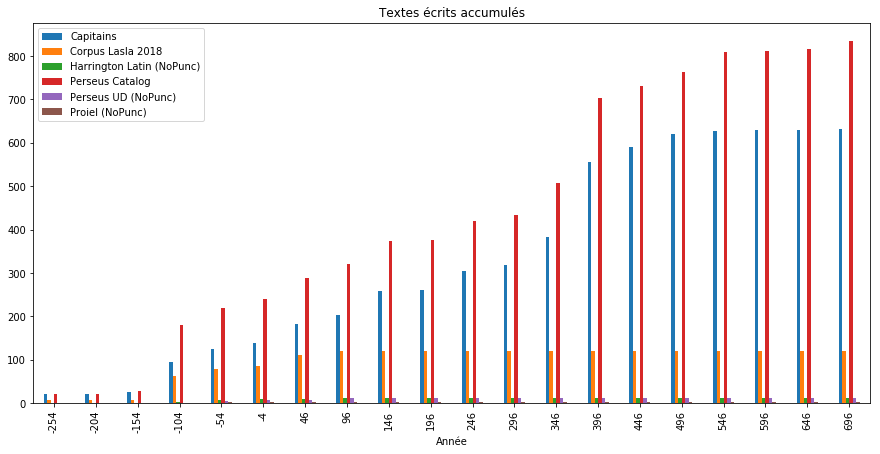

In [9]:
serie = DataFrame([
    {
        "birth": date.birth,
        "death": date.death,
        "Perseus Catalog": catalog_textcount.get(urn, 0),
        "Capitains": available_textcount.get(urn, 0),
        **{
           corpus: lemmatisation_corpora_textcount[corpus].get(urn, 0) for corpus in lemmatisation_corpora_textcount 
        }
    } 
    for urn, date in dates.items()
])


# On liste les colomnes utiles dynamiquement en supprimant celles sans intérêt
cols_to_keep = set(list(serie.columns))
cols_to_keep.remove('death')
cols_to_keep.remove('birth')

# Get simultaneous texts
text_simultaneous = {}
for date in range(Min_date, Max_date+1, 50):
    text_simultaneous[date] = serie[((serie.birth <= date) & (serie.death >= date))][list(cols_to_keep)].sum()
text_simultaneous = DataFrame([{"Année": date, **text_simultaneous[date]} for date in text_simultaneous])

# Get cumulative texts
text_cumulative = {}
for date in range(Min_date, Max_date+1, 50):
    text_cumulative[date] = serie[(serie.birth <= date)][list(cols_to_keep)].sum()
text_cumulative = DataFrame([{"Année": date, **text_cumulative[date]} for date in text_cumulative])


display(HTML(text_simultaneous.to_html()))
text_simultaneous.plot.bar(x="Année", title="Textes écrits par des hauteurs vivant à la date donnée", figsize=(15, 7))
text_cumulative.plot.bar(x="Année", title="Textes écrits accumulés", figsize=(15, 7))